In [25]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats

matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018",]
models = ["inception","minirocket","xresnet1d101"]

In [293]:

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.set(font_scale = 3)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    ax.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    return plt

def get_bp_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    hp = 1 # we dont modify the HP
    sc = 0.5
    for lp in ["30","50","100","500"]:
        try:
            for i in range(20):
                if lp!="500": 
                    df = pd.read_csv("models/bandpassing/csvs/%s_%s_sc-n-bp_%s_%s-%s_%s.csv"%(model_name,dataset,sc,hp,lp,i))
                else:
                    df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_%s_%s.csv"%(model_name,dataset,sc,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,lp)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df["lp"] = float(lp)
                df["bootstrap"] = i
#                 df["hp"] = hp
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df




In [294]:
df = pd.concat([get_bp_experiments(x,"CPSC2018",clf_numbers=False) for x in models]).drop(columns=["dataset_name"])
df = df.melt(id_vars=["classifier_name","lp","bootstrap"])
df

,classifier_name,lp,bootstrap,variable,value
0,inception,30.0,0,1st degree av block,0.867647
1,inception,30.0,1,1st degree av block,0.833333
2,inception,30.0,2,1st degree av block,0.843750
3,inception,30.0,3,1st degree av block,0.850746
4,inception,30.0,4,1st degree av block,0.814815
...,...,...,...,...,...
1675,xresnet1d101,500.0,15,ventricular ectopics,0.683544
1676,xresnet1d101,500.0,16,ventricular ectopics,0.675325
1677,xresnet1d101,500.0,17,ventricular ectopics,0.736196
1678,xresnet1d101,500.0,18,ventricular ectopics,0.759494


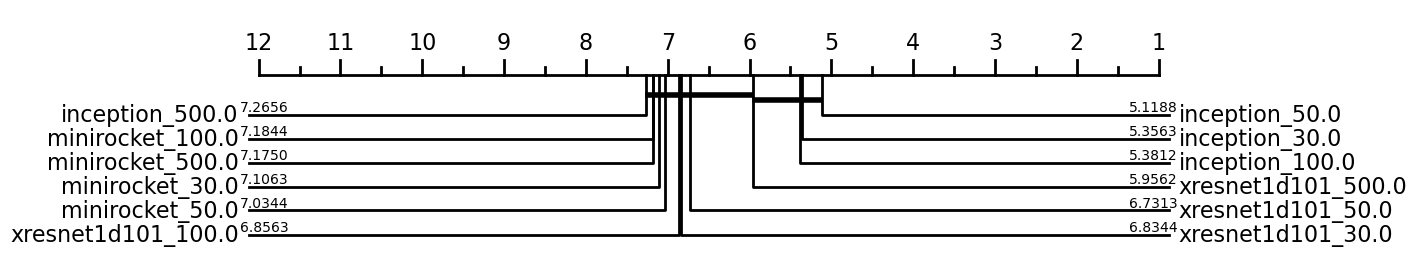

In [295]:
df = pd.concat([get_bp_experiments(x,"ChapmanShaoxing",clf_numbers=False) for x in models]).drop(columns=["dataset_name"])
df = df.melt(id_vars=["classifier_name","lp","bootstrap"])
df_cpsc = pd.DataFrame()
df_cpsc["classifier_name"] = df["classifier_name"] + "_" + df["lp"].astype(str)
df_cpsc["dataset_name"] = df["variable"] +"_"+ df["bootstrap"].astype(str)
df_cpsc["accuracy"] = df["value"]
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_cpsc,alpha=0.05,labels=True)

In [296]:
# correlation between lp and performance
cdf = df[["lp","value"]]
cdf.corr(method="pearson")

,lp,value
lp,1.000000,-0.017628
value,-0.017628,1.000000


In [297]:
# correlation between lowpass and performance for each disease 
gb = df.groupby("variable")
groups = [[gb.get_group(x),x] for x in gb.groups]
[[x[1],x[0][["lp","value"]].corr(method="pearson")["value"][0]] for x in groups]

[['atrial fibrillation', -0.2126854267245268],
 ['left ventricular high voltage', -0.16385873893698313],
 ['nonspecific st t abnormality', -0.03474217544974611],
 ['sinus bradycardia', -0.028445408269347643],
 ['sinus rhythm', 0.062488993377566235],
 ['sinus tachycardia', 0.12001217717937702],
 ['supraventricular tachycardia', -0.1033480742566043],
 ['t wave abnormal', -0.0775763015625021]]

In [298]:
# what factors are important for low-passed results
df_filtered = df[df["lp"]!=500]
for c in df_filtered.columns:
    gb = df_filtered.groupby(c)
    groups = [[gb.get_group(x),x] for x in gb.groups]

    print(c,stats.kruskal(*[g[0]["value"].values for g in groups]))

classifier_name KruskalResult(statistic=3.648615267493736, pvalue=0.16132930443643517)
lp KruskalResult(statistic=0.11663771431422448, pvalue=0.9433491058625432)
bootstrap KruskalResult(statistic=1.373528815504045, pvalue=0.9999999866255607)
variable KruskalResult(statistic=1365.6775633744091, pvalue=1.0296625905484772e-290)
value KruskalResult(statistic=1438.9999999999998, pvalue=1.4661642567267037e-11)


In [292]:
# is there a difference between filtered and unfiltered results?
s1 = df[df["lp"]!=500]["value"]
s2 = df[df["lp"]==500]["value"]
stats.kruskal(s1,s2)

KruskalResult(statistic=0.20292359009786082, pvalue=0.6523712856599244)